In [19]:
import sqlite3
import pandas as pd
import datetime as datetime
import numpy as np
from urllib import parse
import re
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline
import plotly.express as px

In [4]:
import sqlite3
import pandas as pd
import datetime as datetime
import numpy as np
from urllib import parse
import re
#Helper function for decoding blob located withing the attributedBody column in chat.db
#In my case I use the regex function here to only find string sequences in the blob that start with https. and end with ?
#Regex101 website helped a lot with creating this regex function
#Also not that the "ignore" part in url_l.decode("utf-8", "ignore") will ommit certain special characters.
#There are different values you can use for the .decode function so play around with it until you get what works for you
def split_it(url_l):
    url_l = url_l.decode("utf-8", "ignore")
    url_l = ''.join(url_l.split())
    results = re.search('https.+?(?=[?])', url_l)
    if results != None:
        return results.group()
    return None
def getSongs(chat_id, last_updated):
    conn = sqlite3.connect('/Users/williamfoote/Library/Messages/chat.db')
    cur = conn.cursor()
    cur.execute(" select name from sqlite_master where type = 'table' ")
    #Here we are converting the date column from the chat.db file into a more readable datetime format
    messages = pd.read_sql_query('''select ROWID, text, attributedBody, date, handle_id,
    datetime(date/1000000000 + strftime("%s", "2001-01-01") ,"unixepoch","localtime") as
    date_utc FROM message''', conn)
    messages.rename(columns={'ROWID' : 'message_id'}, inplace = True)
    handles = pd.read_sql_query("select ROWID, id from handle", conn)
    handles.rename(columns={'id' : 'phone_number', 'ROWID': 'handle_id'}, inplace = True)
    messagesAndHandlesJoined = pd.merge(messages, handles, on ='handle_id', how='left')
    chatMessagesJoined = pd.read_sql_query("select chat_id, message_id from chat_message_join", conn)
    chatMessagesAndHandlesJoined = pd.merge(messagesAndHandlesJoined,
    chatMessagesJoined, on = 'message_id', how='left')
    #chat id will correspond to a chat in your chat.db file
    #you can print out the chatMessagesJoined table to get an idea of which contacts correspond to which chat
    blobby = chatMessagesAndHandlesJoined[chatMessagesAndHandlesJoined['chat_id'] == chat_id]
    blobby = blobby[['text', 'attributedBody','date_utc']]
    blobby['decoded_blob'] = blobby['attributedBody'].apply(split_it) #Applying the regex function to every blob
    return blobby

In [28]:
# Big thanks to u/Yortos on GitHub for their iMessage analysis tutorial
# Check out their repository (which I got some of this code from) here:
    # https://github.com/yortos/imessage-analysis

# find your chat.db and establish a connection
conn = sqlite3.connect('/Users/williamfoote/Library/Messages/chat.db')
cur = conn.cursor()

# query the database to get all the table names
cur.execute(" select name from sqlite_master where type = 'table' ")
    
contact_list = pd.read_csv("contact_list.csv")
str_pn = ['{0:+d}'.format(raw_pn) for raw_pn in contact_list.phone_number]
contact_list['phone_number'] = pd.Series(str_pn)
    
# If you get an error connecting to chat.db "can't connect", you may need to change your privacy settings
# I'm assuming if you're looking at iMessage data, you're probably on a Mac
# This reddit thread was helpful with the issue:
    # https://www.reddit.com/r/learnpython/comments/adrfew/i_cant_read_db_file_if_its_in_library_folder_macos/

In [30]:
messages

,message_id,guid,text,replace,service_center,handle_id,subject,country,attributedBody,version,...,date_retracted,date_edited,was_detonated,part_count,is_stewie,date_utc,message_date,timestamp,month,year
0,1,75F41F56-B071-44C9-BB38-CF4CF5F6A1AC,None,0,None,0,None,None,b'\x04\x0bstreamtyped\x81\xe8\x03\x84\x01@\x84...,10,...,0,0,0,1,0,2023-02-01 15:43:38,696987818284209792,2023-02-01 15:43:38,2,2023
1,2,6E570F63-95C0-41C0-B053-5DB595F9858D,None,0,None,32,None,None,b'\x04\x0bstreamtyped\x81\xe8\x03\x84\x01@\x84...,10,...,0,0,0,1,0,2023-02-01 15:41:23,696987683772681216,2023-02-01 15:41:23,2,2023
2,3,443B72AF-8468-43C5-9548-F57856DB187C,None,0,None,32,None,None,b'\x04\x0bstreamtyped\x81\xe8\x03\x84\x01@\x84...,10,...,0,0,0,1,0,2023-02-01 15:41:20,696987680985294080,2023-02-01 15:41:20,2,2023
3,4,B8C329A5-0F7F-410F-847A-9285A5FACFC9,None,0,None,0,None,None,b'\x04\x0bstreamtyped\x81\xe8\x03\x84\x01@\x84...,10,...,0,0,0,1,0,2023-02-01 15:36:16,696987376571336320,2023-02-01 15:36:16,2,2023
4,5,F6FEEC9A-9700-44DA-8D33-946A3CE25286,None,0,None,0,None,None,b'\x04\x0bstreamtyped\x81\xe8\x03\x84\x01@\x84...,10,...,0,0,0,1,0,2023-02-01 15:35:54,696987354285254656,2023-02-01 15:35:54,2,2023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316068,316130,44326490-A7D1-44F6-86A8-91DDAF39A107,None,0,None,0,None,None,b'\x04\x0bstreamtyped\x81\xe8\x03\x84\x01@\x84...,10,...,0,0,0,1,0,2023-03-14 18:38:56,700537136643000064,2023-03-14 18:38:56,3,2023
316069,316131,4F1D1017-6C4A-4A65-A05A-EF47069355CA,Watch them lose,0,None,1250,None,None,b'\x04\x0bstreamtyped\x81\xe8\x03\x84\x01@\x84...,10,...,0,0,0,1,0,2023-03-14 18:41:59,700537319908603392,2023-03-14 18:41:59,3,2023
316070,316132,89D91E65-D102-324B-9F9B-0EBA510745C3,Pura Vida: Lazy girl hack -> Stretch Bracelets...,0,None,1540,None,None,b'\x04\x0bstreamtyped\x81\xe8\x03\x84\x01@\x84...,10,...,0,0,0,1,0,2023-03-14 18:46:39,700537599197489920,2023-03-14 18:46:39,3,2023
316071,316133,FAD868C9-A0E3-49B9-9B2B-EA9315784BCA,That pelicans ML would have been massive,0,None,36,None,None,b'\x04\x0bstreamtyped\x81\xe8\x03\x84\x01@\x84...,10,...,0,0,0,1,0,2023-03-14 18:49:00,700537740229265920,2023-03-14 18:49:00,3,2023


In [21]:
# create pandas dataframe with all the tables you care about.

## Mac OSX versions below High Sierra
#messages = pd.read_sql_query('''select *, datetime(date + strftime("%s", "2001-01-01") ,"unixepoch","localtime") 
# as date_utc from message''', conn) 

## High Sierra and above
messages = pd.read_sql_query('''select *, datetime(date/1000000000 + strftime("%s", "2001-01-01")
    ,"unixepoch","localtime")  as date_utc from message''', conn) 

handles = pd.read_sql_query("select * from handle", conn)
chat_message_joins = pd.read_sql_query("select * from chat_message_join", conn)

In [22]:
# These following fields are for cleaning data for date-time analysis
messages['message_date'] = messages['date']
messages['timestamp'] = messages['date_utc'].apply(lambda x: pd.Timestamp(x))
messages['date'] = messages['timestamp'].apply(lambda x: x.date())
messages['month'] = messages['timestamp'].apply(lambda x: int(x.month))
messages['year'] = messages['timestamp'].apply(lambda x: int(x.year))


# rename the ROWID into message_id for clarity
messages.rename(columns={'ROWID' : 'message_id'}, inplace = True)

# rename the handle and apple_id/phone_number as well
handles.rename(columns={'id' : 'phone_number', 'ROWID': 'handle_id'}, inplace = True)

In [24]:
# merge the messages with the handles
merge_level_1 = pd.merge(messages[['text', 'handle_id', 'date','message_date' ,'timestamp', 'month','year','is_sent', 'message_id']],  handles[['handle_id', 'phone_number']], on ='handle_id', how='left')

# and then that table with the chats
df_messages = pd.merge(merge_level_1, chat_message_joins[['chat_id', 'message_id']], on = 'message_id', how='left')


print(len(df_messages))
#print(df_messages.head())

316086


In [25]:
df_messages.loc[df_messages['text'].str.contains("Wordle", na=False)].sort_values(by = 'date')

,text,handle_id,date,message_date,timestamp,month,year,is_sent,message_id,phone_number,chat_id
277376,Wordle 272 5/6\n\n🟩⬛🟨⬛⬛\n🟩⬛⬛⬛🟨\n🟩🟨🟨🟨⬛\n🟩🟩🟨🟨⬛\n...,38,2022-03-18,669281826457856128,2022-03-18 00:37:06,3,2022,0,277428,+12089820639,1720.0
277380,Wordle 272 6/6\n\n⬛⬛🟨⬛⬛\n🟨⬛⬛⬛⬛\n⬛⬛🟨🟨⬛\n⬛🟩🟨🟨🟨\n...,32,2022-03-18,669281668335308288,2022-03-18 00:34:28,3,2022,0,277432,+18016631007,1720.0
277229,Wordle 272 3/6\n\n⬛🟩🟨🟨🟨\n⬛🟩🟨🟩🟩\n🟩🟩🟩🟩🟩,91,2022-03-18,669304465277312256,2022-03-18 06:54:25,3,2022,0,277281,+19253543903,1720.0
277233,Wordle 272 4/6\n\n⬛⬛⬛🟨⬛\n⬛🟨🟨⬛🟨\n🟩🟨🟨🟨⬛\n🟩🟩🟩🟩🟩,37,2022-03-18,669288599073667968,2022-03-18 02:29:59,3,2022,0,277285,+19496329313,1720.0
277360,Wordle 272 4/6\n\n🟩⬜🟨⬜🟩\n🟩🟩⬜⬜🟩\n🟩🟩🟩⬜🟩\n🟩🟩🟩🟩🟩,0,2022-03-18,669305479569000064,2022-03-18 07:11:19,3,2022,1,277412,NaN,1720.0
...,...,...,...,...,...,...,...,...,...,...,...
314166,Wordle 629 4/6\n\n⬜⬜🟦🟧⬜\n⬜🟦⬜🟧⬜\n⬜⬜🟦🟧🟧\n🟧🟧🟧🟧🟧,0,2023-03-10,700156513240103296,2023-03-10 07:55:13,3,2023,1,314215,NaN,1720.0
314831,Wordle 630 4/6\n\n⬜🟦🟦🟦⬜\n⬜🟦🟦🟦⬜\n⬜🟦⬜🟦🟧\n🟧🟧🟧🟧🟧,0,2023-03-11,700237164260940288,2023-03-11 06:19:24,3,2023,1,314880,NaN,1720.0
315294,Wordle 631 4/6\n\n⬜⬜⬜⬜🟦\n⬜⬜🟧🟧⬜\n⬜🟧🟧🟧🟧\n🟧🟧🟧🟧🟧,0,2023-03-12,700374355675660800,2023-03-12 21:25:55,3,2023,1,315343,NaN,1720.0
315468,Wordle 632 5/6\n\n⬜⬜⬜⬜⬜\n⬜⬜⬜⬜🟧\n⬜🟧🟧⬜🟧\n⬜🟧🟧🟧🟧\n...,0,2023-03-13,700419168250065280,2023-03-13 09:52:48,3,2023,1,315517,NaN,1720.0


In [26]:
wordle_scores = df_messages.loc[df_messages['text'].str.contains("Wordle", na=False)]

In [27]:
wordle_scores.loc[wordle_scores['text'].str.contains('“Wordle ', na=False)]

,text,handle_id,date,message_date,timestamp,month,year,is_sent,message_id,phone_number,chat_id
267750,Exclamó por “Wordle 527 2/6\n\n⬛⬛🟨🟨⬛\n🟩🟩🟩🟩🟩”,37,2022-11-28,691341647033623040,2022-11-28 07:20:47,11,2022,0,267802,+19496329313,1720.0
267755,Emphasized “Wordle 527 2/6\n\n⬛⬛🟨🟨⬛\n🟩🟩🟩🟩🟩”,0,2022-11-28,691340861029000064,2022-11-28 07:07:41,11,2022,1,267807,NaN,1720.0
267858,Disliked “Wordle 513 2/6\n\n⬜🟧🟦🟦⬜\n🟧🟧🟧🟧🟧”,34,2022-11-14,690146031622981120,2022-11-14 11:13:51,11,2022,0,267910,+14086660152,1720.0
267953,Loved “Wordle 511 2/6\n\n⬜🟧🟧🟧🟧\n🟧🟧🟧🟧🟧\nSkill”,91,2022-11-12,689976136180892032,2022-11-12 12:02:16,11,2022,0,268005,+19253543903,1720.0
270322,Emphasized “Wordle 481 2/6\n\n⬛⬛🟩⬛🟨\n🟩🟩🟩🟩🟩”,0,2022-10-13,687365926029000064,2022-10-13 07:58:46,10,2022,1,270374,NaN,1720.0
270372,Exclamó por “Wordle 481 2/6\n\n⬛⬛🟩⬛🟨\n🟩🟩🟩🟩🟩”,37,2022-10-13,687370158390800256,2022-10-13 09:09:18,10,2022,0,270424,+19496329313,1720.0
274229,Emphasized “Wordle 427 2/6\n\n⬜🟦⬜🟦🟧\n🟧🟧🟧🟧🟧”,36,2022-08-20,682711823091593088,2022-08-20 11:10:23,8,2022,0,274281,+18182991475,1720.0
274237,Emphasized “Wordle 427 2/6\n\n⬜🟦⬜🟦🟧\n🟧🟧🟧🟧🟧”,39,2022-08-20,682711433781851008,2022-08-20 11:03:53,8,2022,0,274289,+13105147216,1720.0
274245,Exclamó por “Wordle 427 2/6\n\n⬜🟦⬜🟦🟧\n🟧🟧🟧🟧🟧”,37,2022-08-20,682711120184981120,2022-08-20 10:58:40,8,2022,0,274297,+19496329313,1720.0
274314,Loved “Wordle 427 2/6\n\n⬜🟦⬜🟦🟧\n🟧🟧🟧🟧🟧”,91,2022-08-20,682711116167673088,2022-08-20 10:58:36,8,2022,0,274366,+19253543903,1720.0


In [9]:
# # I needed to clean a lot of phrases. If someone in the message reacted to one's Wordle text, I need to remove
# # That row. E.g. Bob Laughed at "Wordle 243 X/6" should be removed
# rm_laugh = wordle_scores.loc[~wordle_scores['text'].str.contains('Laughed', na=False)]
# rm_emp = rm_laugh.loc[~rm_laugh['text'].str.contains('Emphasized', na=False)]
# rm_love = rm_emp.loc[~rm_emp['text'].str.contains('Loved', na=False)]
# rm_dl = rm_love.loc[~rm_love['text'].str.contains('Disliked', na=False)]
# rm_like = rm_dl.loc[~rm_dl['text'].str.contains('Liked', na=False)]

# # I also subsetted on messages that contained a green box (originally I chose a black box, but some people
# # For whatever reason are in light mode, so green box was better in my opinion)

# boxes = rm_like.loc[rm_like['text'].str.contains('🟩|🟧', na=False, regex=True)]

# # Someone's language settings in my groupchat was set to Spanish, so "Exclamo" came up a few times
# rm_exclam = boxes.loc[~boxes['text'].str.contains('Exclam', na=False)]
# rm_gust = rm_exclam.loc[~rm_exclam['text'].str.contains('Le gust', na=False)]
# rm_encant = rm_gust.loc[~rm_gust['text'].str.contains('Le encan', na=False)]

# # I exported to a csv to check all was well
# rm_encant.to_csv("imessages.csv")

In [13]:
# I consolidated the chunk above to the three lines below

# I noticed that the above code is so unneccessary
# Just subset the ones that don't have "Wordle because all reaction texts include this
# Note: I assume no one does something like put their Wordle score in quotes for no reason
rm_react = wordle_scores.loc[~wordle_scores['text'].str.contains('“Wordle ', na=False)]

# Below will remove instances where someone didn't get a single correct letter
# That result was probably them trolling anyway, so it's not too bad to remove
# That outlier.

# 5/11/22: Added functionality for Wordle's new accessiblity mode (replaces yellow
# and green boxes with orange and blue ones
boxes = rm_react.loc[rm_react['text'].str.contains('🟩|🟧', na=False, regex=True)]

# I exported to a csv to check all was well
boxes.to_csv("imessages.csv")

In [14]:
cleaned = boxes.copy(deep=True)

In [15]:
# Make empty list for scores, I'll put the scores as an integer in here for each row
# Current row is something like "Wordle 243 2/6 ..."
# Need to strip it down to just the 2 before the /6
# Use regular expressions to do this
score = []
for line in cleaned.text:
    raw_score = re.findall(r".\/6", line)[0]
    format_score = re.sub('\/6', "", raw_score)
    format_score_misses = int(re.sub('X', '7', format_score))
    score.append(format_score_misses)
len(score)
# Update: 4/4/22 - This number was 533.

160

In [13]:
wordle_num = []
for line in cleaned.text:
    this_num = int(re.findall(r"\d+(?= \w)", line)[0])
    wordle_num.append(this_num)

In [14]:
# Put these results in a dataframe and concatenate with the cleaned dataframe
score_df = pd.DataFrame(score)
wordle_num_df = pd.DataFrame(wordle_num)
cleaned_df = pd.concat([wordle_num_df, cleaned.reset_index(drop=True), score_df], axis =1, ignore_index = True)
cleaned_df.columns = ['wordle_num', 'text', 'handle_id', 'date', 'message_date', 'timestamp', 'month',
                      'year', 'is_sent', 'message_id', 'phone_number', 'chat_id', 'score']

In [15]:
# Here I changed the numbers to the person's name
# Note that my texts were showing up as NaNs in the phone_number column, so I put my name in here
# cleaned_df.loc[pd.isnull(cleaned_df['phone_number']), 'phone_number'] = 'Will'
# cleaned_df.loc[cleaned_df['phone_number'] == '+18016631007', 'phone_number'] = 'Bobbette'
# cleaned_df.loc[cleaned_df['phone_number'] == '+18307193677', 'phone_number'] = 'Bobia'
# cleaned_df.loc[cleaned_df['phone_number'] == '+19253543903', 'phone_number'] = 'Boba'
# cleaned_df.loc[cleaned_df['phone_number'] == '+14086660152', 'phone_number'] = 'Robin'
# cleaned_df.loc[cleaned_df['phone_number'] == '+19496329313', 'phone_number'] = 'Bob'
# cleaned_df.loc[cleaned_df['phone_number'] == '+12089820639', 'phone_number'] = 'Bobby'
# cleaned_df.loc[cleaned_df['phone_number'] == '+13105147216', 'phone_number'] = 'Bobbie'
# cleaned_df.loc[cleaned_df['phone_number'] == '+12167125706', 'phone_number'] = 'Rob'
# cleaned_df.loc[cleaned_df['phone_number'] == '+18182991475', 'phone_number'] = 'Robert'
# cleaned_df.loc[cleaned_df['phone_number'] == '+12408880323', 'phone_number'] = 'Robby'


# cleaned_df.loc[pd.isnull(cleaned_df['phone_number']), 'phone_number'] = 'Will'
# cleaned_df.loc[cleaned_df['phone_number'] == '+18016631007', 'phone_number'] = 'Isabel'
# cleaned_df.loc[cleaned_df['phone_number'] == '+18307193677', 'phone_number'] = 'Daria'
# cleaned_df.loc[cleaned_df['phone_number'] == '+19253543903', 'phone_number'] = 'Jenna'
# cleaned_df.loc[cleaned_df['phone_number'] == '+14086660152', 'phone_number'] = 'Varun'
# cleaned_df.loc[cleaned_df['phone_number'] == '+19496329313', 'phone_number'] = 'Ben'
# cleaned_df.loc[cleaned_df['phone_number'] == '+12089820639', 'phone_number'] = 'Macy'
# cleaned_df.loc[cleaned_df['phone_number'] == '+13105147216', 'phone_number'] = 'Hari'
# cleaned_df.loc[cleaned_df['phone_number'] == '+12167125706', 'phone_number'] = 'Armaan'
# cleaned_df.loc[cleaned_df['phone_number'] == '+18182991475', 'phone_number'] = 'Nick'
# cleaned_df.loc[cleaned_df['phone_number'] == '+12408880323', 'phone_number'] = 'Joey'

In [15]:
time_til_mid = []
hr_min = []
for row in cleaned.timestamp:
    hr, minute = row.timetuple()[3:5]
    hrmin = hr + minute/60
    ttm = 24-hrmin
    time_til_mid.append(ttm)
    hr_min.append(hrmin)
time_til_mid_df = pd.DataFrame(time_til_mid)
time_til_mid_df.columns = ['time_til_mid']
hrmin_df = pd.DataFrame(hr_min)
hrmin_df.columns = ['time_from_mid']
cleaned_temp = cleaned_df.copy(deep = True)
time_df = pd.concat([cleaned_temp, time_til_mid_df, hrmin_df], axis = 1)

In [16]:
gm_wordle = time_df.loc[time_df.chat_id == 1720]
cleaned_df_2 = pd.merge(gm_wordle, contact_list, on = 'phone_number', how = 'left')
cleaned_df_2 = cleaned_df_2.sort_values(['date']).reset_index(drop = True)
cleaned_df_2.loc[pd.isnull(cleaned_df_2['phone_number']), 'name_2'] = 'Will'
cleaned_df_2.loc[pd.isnull(cleaned_df_2['phone_number']), 'name'] = 'Will'
cleaned_df_2.loc[pd.isnull(cleaned_df_2['phone_number']), 'phone_number'] = '+12092263572'
cleaned_df_2['score_7'] = cleaned_df_2.groupby('name_2')['score']\
.transform(lambda x: x.rolling(7, 1).mean())
cleaned_df_2['cum_score'] = (cleaned_df_2.groupby('name_2')['score'].apply(lambda x: x.shift().expanding().mean()))
cleaned_df_2['time_fm_7'] = cleaned_df_2.groupby('name_2')['time_from_mid']\
.transform(lambda x: x.rolling(7, 1).mean())
cleaned_df_2['time_tm_7'] = cleaned_df_2.groupby('name_2')['time_til_mid']\
.transform(lambda x: x.rolling(7, 1).mean())
cleaned_df_2['cum_time_fm'] = (cleaned_df_2.groupby('name_2')['time_from_mid'].apply(lambda x: x.shift().expanding().mean()))
cleaned_df_2['cum_time_tm'] = (cleaned_df_2.groupby('name_2')['time_til_mid'].apply(lambda x: x.shift().expanding().mean()))
mean_score = cleaned_df_2.score.mean(skipna=True)
cleaned_df_2.to_csv('test_data.csv')

/var/folders/64/kktgr_017td3vw1nnvpfz4hw0000gn/T/ipykernel_67772/3439593813.py:9: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  cleaned_df_2['cum_score'] = (cleaned_df_2.groupby('name_2')['score'].apply(lambda x: x.shift().expanding().mean()))
/var/folders/64/kktgr_017td3vw1nnvpfz4hw0000gn/T/ipykernel_67772/3439593813.py:14: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future be

In [17]:
winners = cleaned_df_2.groupby('wordle_num')['score'].min().reset_index()
winners.rename(columns = {'score':'winning_score'}, inplace = True)
speeders = cleaned_df_2.groupby('wordle_num')['time_from_mid'].min().reset_index()
speeders.rename(columns = {'time_from_mid':'winning_time'}, inplace = True)


In [18]:
cleaned_df_2.groupby('wordle_num')['timestamp'].min().reset_index()


,wordle_num,timestamp
0,272,2022-03-18 00:08:13
1,305,2022-04-20 00:07:19
2,369,2022-06-22 22:04:42
3,370,2022-06-23 21:04:33
4,371,2022-06-24 11:42:57
5,391,2022-07-15 21:58:32
6,392,2022-07-15 21:01:46
7,402,2022-07-26 22:58:36
8,403,2022-07-26 22:03:29
9,404,2022-07-27 21:02:39


In [19]:
winner_dummy = []
for i in range(len(cleaned_df_2)):
    this_row = cleaned_df_2.iloc[[i]]
    temp = winners.merge(this_row[['wordle_num', 'score']], on = 'wordle_num', how = 'right')
    if temp['winning_score'].item() == temp['score'].item():
        winner_dummy.append(1)
    else:
        winner_dummy.append(0)
winner_df = pd.DataFrame(winner_dummy)
winner_df.columns = ['winner_dummy']

speeder_dummy = []
for i in range(len(cleaned_df_2)):
    this_row = cleaned_df_2.iloc[[i]]
    temp = speeders.merge(this_row[['wordle_num', 'time_from_mid']], on = 'wordle_num', how = 'right')
    if temp['winning_time'].item() == temp['time_from_mid'].item():
        speeder_dummy.append(1)
    else:
        speeder_dummy.append(0)
speeder_df = pd.DataFrame(speeder_dummy)
speeder_df.columns = ['speeder_df']

In [20]:
new = pd.concat([cleaned_df_2, winner_df, speeder_df], axis = 1)

In [21]:
#################################################
#### 3.E Adding rolling and cumulative means ####
#################################################

rolling_line_fig_score = px.line(data_frame=cleaned_df_2, x='date', y='cum_score', title='Rolling Weekly Mean for Score', color = 'name_2')
rolling_line_fig_time = px.line(data_frame=new, x='date', y='cum_time_fm', title='Rolling Weekly Mean for Time', color = 'name_2')

score_bar_fig = px.histogram(data_frame = new, x="score")
mean_score = new.score.mean(skipna=True)

In [22]:
rolling_line_fig_time

/var/folders/64/kktgr_017td3vw1nnvpfz4hw0000gn/T/ipykernel_67772/3575831307.py:4: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.

/var/folders/64/kktgr_017td3vw1nnvpfz4hw0000gn/T/ipykernel_67772/3575831307.py:4: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.



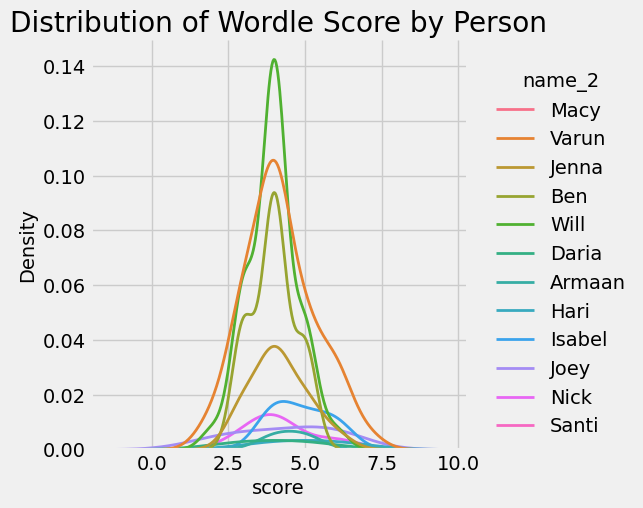

In [23]:
import seaborn as sns


sns.displot(new, x="score", hue="name_2", kind = "kde",
            linewidth = 2).set(title = "Distribution of Wordle Score by Person")
plt.savefig('girls_wordle_group.png', dpi=300, bbox_inches='tight')


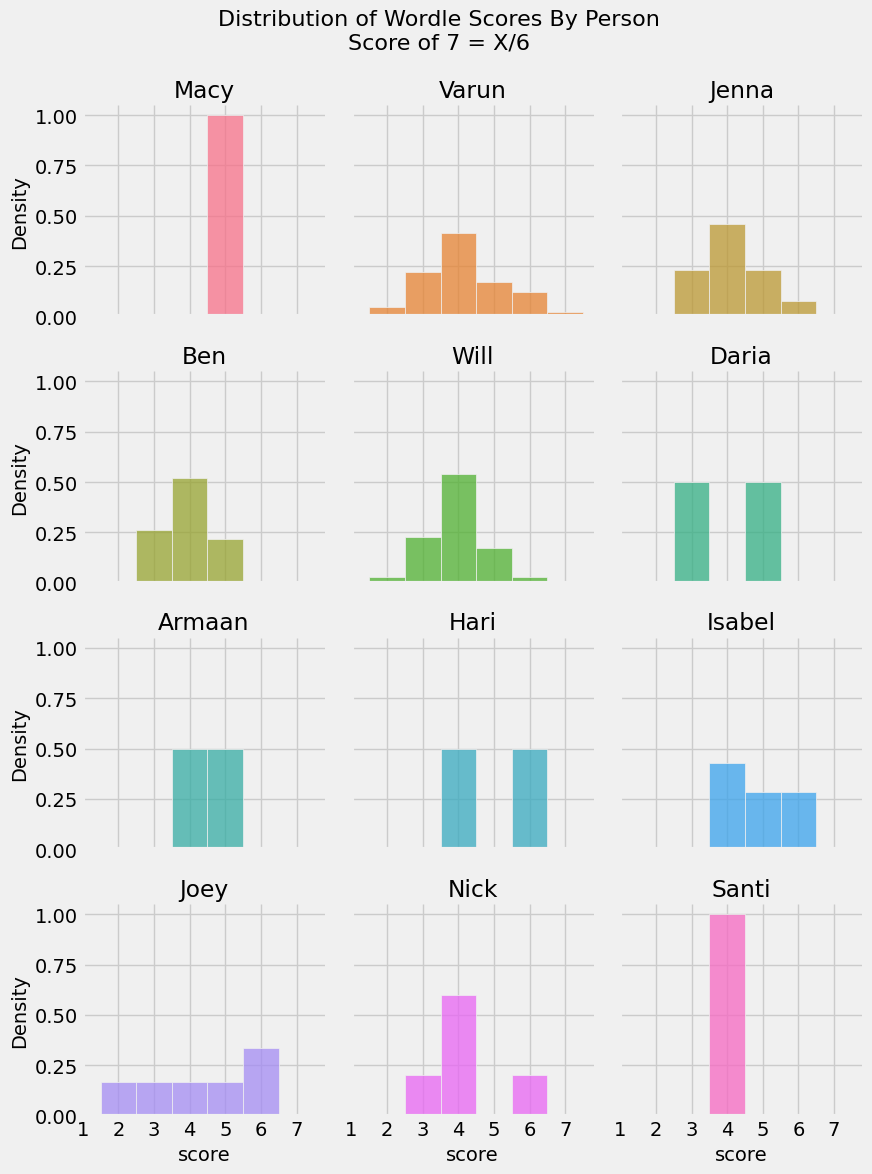

In [24]:
h = sns.FacetGrid(new, col='name_2', hue='name_2', col_wrap = 3)



h.map(sns.histplot, "score", discrete = True, stat = "density")

[plt.setp(ax.texts, text="") for ax in h.axes.flat] # remove the original texts
                                                    # important to add this before setting titles
h.set_titles(col_template = '{col_name}')

# Add an overall title and move it above the graphs
h.fig.subplots_adjust(top=.9) 
h.fig.suptitle('Distribution of Wordle Scores By Person\nScore of 7 = X/6', size = 16)


h.set(xticks=[1, 2, 3, 4, 5, 6, 7])
h.set_xticklabels([1, 2, 3, 4, 5, 6, 7])
plt.savefig('girls_wordle_indiv.png', dpi=300)

In [25]:
new.groupby("name_2")['time_from_mid'].describe().sort_values('mean', ascending=False).reset_index()

,name_2,count,mean,std,min,25%,50%,75%,max
0,Joey,6.0,20.711111,0.817290,19.050000,20.954167,21.025000,21.058333,21.166667
1,Jenna,13.0,14.669231,6.530001,5.850000,9.583333,13.766667,21.716667,22.966667
2,Santi,2.0,11.625000,16.157390,0.200000,5.912500,11.625000,17.337500,23.050000
3,Isabel,7.0,10.869048,10.994996,0.050000,0.608333,8.033333,22.025000,22.733333
4,Will,35.0,9.735714,4.755671,0.033333,7.333333,8.316667,10.766667,23.900000
5,Ben,23.0,8.284058,6.550402,0.083333,4.841667,7.950000,9.450000,22.700000
6,Nick,5.0,7.926667,3.831170,1.366667,8.133333,9.433333,9.450000,11.250000
7,Hari,2.0,4.475000,6.140044,0.133333,2.304167,4.475000,6.645833,8.816667
8,Varun,41.0,1.976016,4.676687,0.000000,0.033333,0.083333,0.500000,22.050000
9,Daria,2.0,0.683333,0.235702,0.516667,0.600000,0.683333,0.766667,0.850000


In [79]:
new.groupby("name_2")['score'].describe().sort_values('mean', ascending=True).reset_index()

,name_2,count,mean,std,min,25%,50%,75%,max
0,Ben,234.0,3.769231,1.071557,1.0,3.0,4.0,4.00,7.0
1,Will,287.0,3.972125,1.037373,2.0,3.0,4.0,5.00,7.0
2,Macy,120.0,3.983333,1.020655,2.0,3.0,4.0,5.00,6.0
3,Jenna,168.0,4.041667,0.974859,2.0,3.0,4.0,5.00,6.0
4,Varun,297.0,4.043771,1.004098,2.0,3.0,4.0,5.00,7.0
5,Daria,122.0,4.049180,0.934663,2.0,3.0,4.0,5.00,6.0
6,Nick,125.0,4.072000,1.086397,2.0,3.0,4.0,5.00,6.0
7,Isabel,136.0,4.161765,0.952351,2.0,4.0,4.0,5.00,7.0
8,Santi,6.0,4.333333,1.032796,3.0,4.0,4.0,4.75,6.0
9,Hari,102.0,4.401961,1.204446,2.0,4.0,4.0,5.00,7.0


In [26]:
pd.DataFrame(new.groupby('name_2').agg(Wins = ('winner_dummy', 'sum'), Games_Played = ('winner_dummy', 'count'))).unstack()

              name_2
Wins          Armaan     1
              Ben       12
              Daria      1
              Hari       0
              Isabel     2
              Jenna      7
              Joey       3
              Macy       0
              Nick       2
              Santi      1
              Varun     28
              Will      17
Games_Played  Armaan     2
              Ben       23
              Daria      2
              Hari       2
              Isabel     7
              Jenna     13
              Joey       6
              Macy       1
              Nick       5
              Santi      2
              Varun     41
              Will      35
dtype: int64

In [115]:
new.groupby('name_2').agg(Wins = ('winner_dummy', 'sum'), Games_Played = ('winner_dummy', 'count')).apply(lambda x: x.Wins/x.Games_Played)

AttributeError: 'Series' object has no attribute 'Wins'

/Users/williamfoote/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


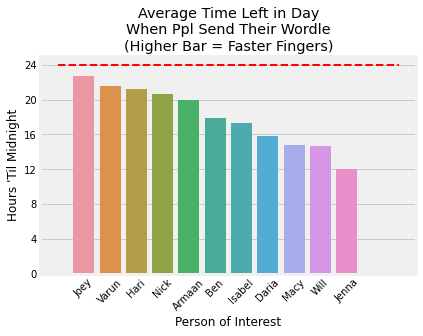

In [ ]:
ttm_agged = girls_wordle.groupby("phone_number")['TimeTilMidnight'].mean().sort_values(ascending = False)
sns.barplot(ttm_agged.index, ttm_agged.values).set(
    title='Average Time Left in Day\nWhen Ppl Send Their Wordle\n(Higher Bar = Faster Fingers)',
    xlabel='Person of Interest', ylabel="Hours 'Til Midnight", ylim = (0, 25))
line1, = plt.plot([-1, 12], [24, 24], '--', linewidth=2, color='red')
plt.xticks(rotation = 45)
plt.yticks(np.arange(28, step = 4))
plt.savefig('girls_wordle_speed_high.png', dpi=300, bbox_inches='tight')

/Users/williamfoote/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


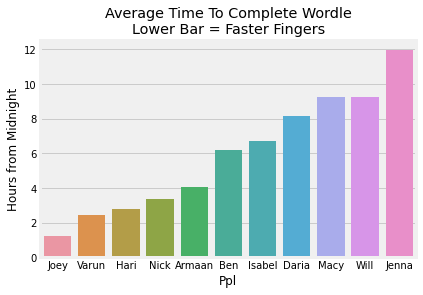

In [ ]:
hrmin_agged = girls_wordle.groupby("phone_number")['HourMin'].mean().sort_values(ascending = True)
sns.barplot(ttm_agged.index, hrmin_agged.values).set(
    title='Average Time To Complete Wordle\nLower Bar = Faster Fingers',
    xlabel='Ppl', ylabel='Hours from Midnight')
plt.savefig('girls_wordle_speed.png', dpi=300)

/Users/williamfoote/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


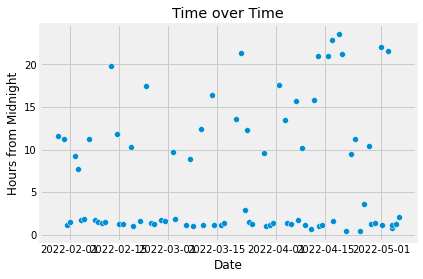

In [ ]:
sns.scatterplot(girls_wordle.loc[girls_wordle.phone_number == 'Isabel', 'timestamp'],
                girls_wordle.loc[girls_wordle.phone_number == 'Isabel', 'HourMin'],
                data = girls_wordle).set(
                    title='Time over Time',
                    xlabel='Date', ylabel='Hours from Midnight')

plt.savefig('girls_wordle_isabelspeed.png', dpi=300, bbox_inches='tight')


/Users/williamfoote/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


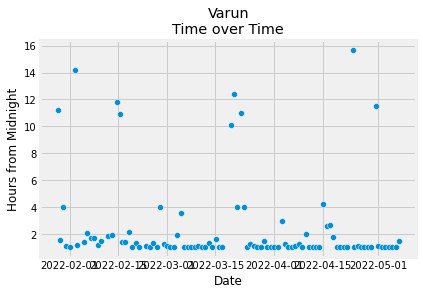

In [ ]:
sns.scatterplot(girls_wordle.loc[girls_wordle.phone_number == 'Varun', 'timestamp'],
                girls_wordle.loc[girls_wordle.phone_number == 'Varun', 'HourMin'],
                data = girls_wordle).set(
                    title='Varun\nTime over Time',
                    xlabel='Date', ylabel='Hours from Midnight')

plt.savefig('girls_wordle_isabelspeed.png', dpi=300, bbox_inches='tight')


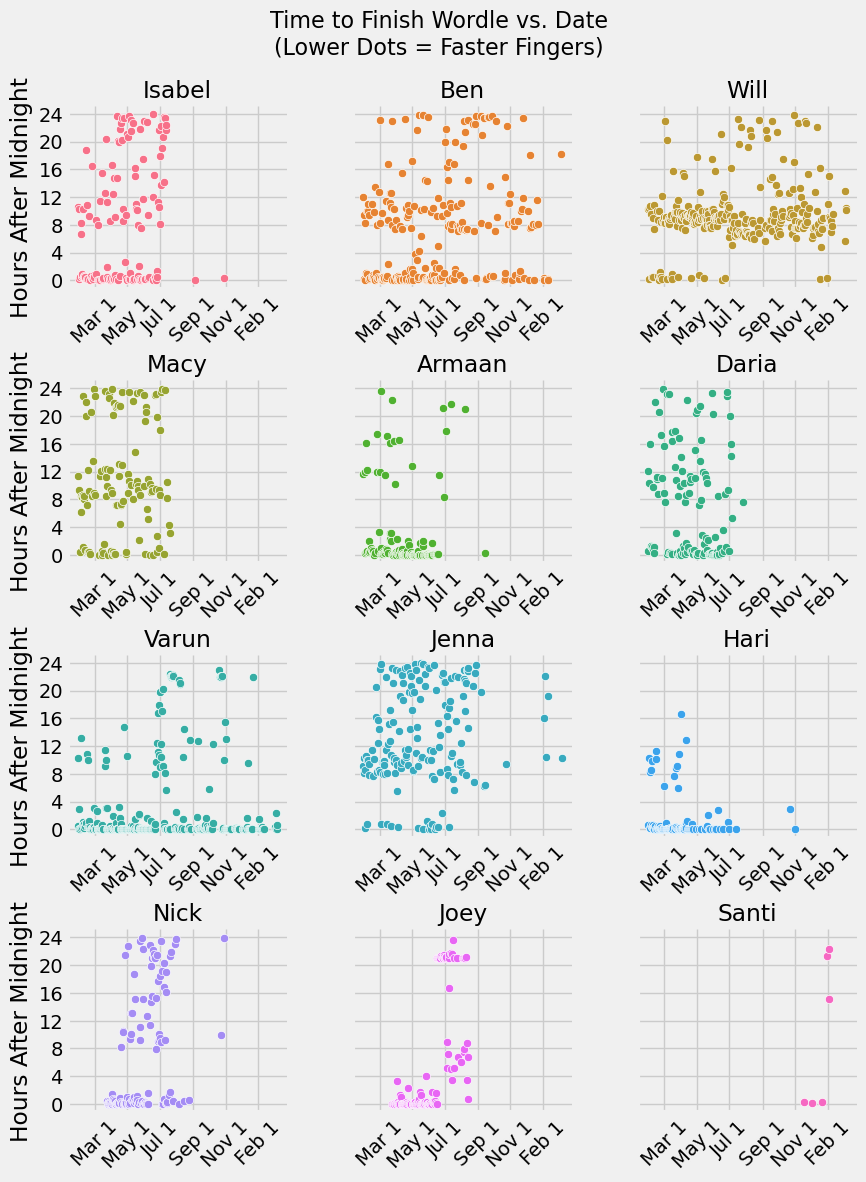

In [82]:
g = sns.FacetGrid(new, hue = 'name_2', col = 'name_2', col_wrap = 3)
g.map(sns.scatterplot, "timestamp", "time_from_mid")

# Add ticks to every subplot
for ax in g.axes.flatten():
    ax.tick_params(axis = 'x', labelbottom=True, rotation = 45)
    
    
# Add labels to every subplot
g.set(xlabel='', ylabel='Hours After Midnight')

# Add an overall title and move it above the graphs
g.fig.subplots_adjust(top=.9) 
g.fig.suptitle('Time to Finish Wordle vs. Date\n(Lower Dots = Faster Fingers)', size = 16)

[plt.setp(ax.texts, text="") for ax in g.axes.flat] # remove the original texts
                                                    # important to add this before setting titles
g.set_titles(col_template = '{col_name}')

# Editing labels and titles with plt

# I want the date to be reformatted nicely on the x-axis ticks
loc, labels = plt.xticks()
plt.xticks(loc, ['Mar 1', 'May 1', 'Jul 1', 'Sep 1', 'Nov 1', 'Feb 1'])

# And I want hours til midnight to be plotted on the y-axis ticks
plt.yticks(np.arange(28, step = 4))
plt.subplots_adjust(hspace=0.5, wspace=0.3)

plt.savefig('girls_wordle_speed_scatter.png', dpi=300, bbox_inches='tight')


In [ ]:
d = cleaned.text
re.findall(r".\/6", d.iloc[0])

['4/6']

/Users/williamfoote/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='HourMin', ylabel='score'>

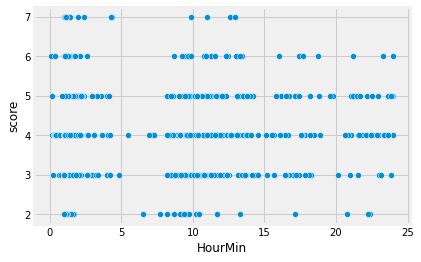

In [ ]:
sns.scatterplot(girls_wordle.HourMin, girls_wordle.score, data = girls_wordle)